In [1]:
import math
import scipy.stats as stats
%pylab inline
import pylab, sys
from scipy.optimize import fsolve
from random import random
import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def std_dev(a_list): # Computes the Standard Deviation, taken from Alex Orange
    mean = sum(a_list)/len(a_list)
    return math.sqrt(sum([(_-mean)**2 for _ in a_list])/(len(a_list)-1))

def var(a_list):
    mean = sum(a_list)/len(a_list)
    return(math.sqrt(sum([(_-mean)**2 for _ in a_list])/(len(a_list)-1))**2)

# Function to find covariance
# Source: https://www.geeksforgeeks.org/program-find-covariance/
#  Covariance is a measure of how much two random variables vary together
def cov(arr1, arr2, n): 
    s = 0.0
    for i in range(0, n): 
        s = (s + (arr1[i] - mean(arr1, n)) *
                      (arr2[i] - mean(arr2, n))) 
    return s / (n - 1.0)

# Function to calculate expectation value 
# Source: https://www.geeksforgeeks.org/expectation-expected-value-array/
def expectation(a_list, n): 
    # probability that is the same for each element 
    prb = 1.0 / n 
    # calculating expectation overall 
    s = 0
    for i in range(0, n): 
        s += (a_list[i] * prb) # sum
    return float(s) 

# Function to find mean
def mean(arr, n): # Function to find mean.
    s = 0.0
    for i in range(0, n): 
        s = s + arr[i] 
    return s / n

def f2M(x): # converts feet to meters 
    Meter = x/(3.28084)
    return Meter

def m2Km(x): #Convert meters to kilometers 
    km = 0.001*x
    return km

def gps2Dec(degrees, minutes, seconds): # Converts GPS coordinates to Lat and Long in decimal
    D = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    return D

In [3]:
# Uses the Haversine formula to calculate the distance (in meters) between 
# two points given their longitude and latitude in decimal format.
# The Haversine function is defined as: hav(theta) = sin^2(theta/2)
# From: https://en.wikipedia.org/wiki/Haversine_formula
# & https://rosettacode.org/wiki/Haversine_formula#Python
def haverDist(lat1, long1, lat2, long2):
    R      = 6.371009e6 # Earths Radius (m) or 6371.009 (km) or 3958.7613 (miles)
    Long1  = math.radians(long1)
    Lat1   = math.radians(lat1)
    Long2  = math.radians(long2)
    Lat2   = math.radians(lat2)
    dLat   = Lat2 - Lat1
    dLong  = Long2 - Long1 
    eqn1   = math.sin(dLat/2)**2 + math.cos(Lat1)*math.cos(Lat2)*math.sin(dLong/2)**2
    HavDis = R*2*math.atan2(math.sqrt(eqn1), math.sqrt(1-eqn1)) # atan2(y,x) = atan(y/x)
    return HavDis

def haverDist2(transmit1, transmit2):
    lat1, long1, _ = transmit1
    lat2, long2, _ = transmit2
    return haverDist(lat1, long1, lat2, long2)

In [4]:
# Convert Lat, Lon, Altitude to Earth-Centered-Earth-Fixed (ECEF)
# Returns x, y, z in meters. Assumes the elevation to be in feet and then converts it to meters.
# SOURCE: http://danceswithcode.net/engineeringnotes/geodetic_to_ecef/geodetic_to_ecef.html
# TEST ACCURACY: https://www.oc.nps.edu/oc2902w/coord/llhxyz.htm?source=post_page---------------------------
def LatLon2xyz(lat, lon, alt):
    alt   = alt/(3.28084)            # Convert elevation from feet to meters
    lat   = math.radians(lat)                # Convert degrees to radians
    lon   = math.radians(lon)                # Convert degrees to radians
    ec    = 6.6943799901377997e-3   # WGS-84 first eccentricity squared
    a     = 6378137.0               # WGS-84 semi-major axis
    Erad  = 6.371009e6              # Earths radius in meters
    n     = a/math.sqrt(1 - ec*math.sin(lat)*math.sin(lat))
    ecefX = (n + alt)*math.cos(lat)*math.cos(lon)
    ecefY = (n + alt)*math.cos(lat)*math.sin(lon)
    ecefZ = (n*(1 - ec) + alt)*math.sin(lat)
    return ecefX, ecefY, ecefZ

# Use this function to convert x,y,z back to Lat, Lon, Altitude respectively
# Assumes all x,y,z values are in meters and returns Altitude in meters
# SOURCE: http://danceswithcode.net/engineeringnotes/geodetic_to_ecef/geodetic_to_ecef.html
def xyz2LatLon(x, y, z):
    a  = 6378137.0              # WGS-84 semi-major axis
    e2 = 6.6943799901377997e-3  # WGS-84 first eccentricity squared
    a1 = 4.2697672707157535e+4  # a1 = a*e2
    a2 = 1.8230912546075455e+9  # a2 = a1*a1
    a3 = 1.4291722289812413e+2  # a3 = a1*e2/2
    a4 = 4.5577281365188637e+9  # a4 = 2.5*a2
    a5 = 4.2840589930055659e+4  # a5 = a1+a3
    a6 = 9.9330562000986220e-1  # a6 = 1-e2
    w2 = x*x + y*y 
    w  = math.sqrt(w2)
    r2 = w2 + z*z
    r  = math.sqrt(r2)
    Lon = math.atan2(y, x) # Lon 
    s2 = z*z/r2
    c2 = w2/r2
    u = a2/r
    v = a3 - (a4/r)
    if(c2 > 0.3):
        s = (math.sqrt(z**2)/r)*(1.0 + c2*(a1+u+s2*v)/r) # z shouid be positive |z|
        Lat = math.asin(s) # Lat
        ss = s*s
        c = math.sqrt(1.0-ss)
    else:
        c = (w/r)*(1.0 - s2*(a5-u-c2*v)/r)
        Lat = math.acos(c) # Lat
        ss = 1.0 - c*c
        s = math.sqrt(ss)
    rg = a/math.sqrt(1.0 - e2*ss)
    rf = a6*rg
    u = w - rg*c
    v = math.sqrt(z**2) - rf*s # z shouid be positive |z|
    f = c*u + s*v
    m = c*v - s*u
    p = m/((rf/(1.0 - e2*ss))+f) 
    Lat = Lat + p # Lat
    Alt = f + m*p/2.0 # Altitude
    if(z < 0.0):
        Lat *= -1.0 # Lat
    Lat = (180.0/math.pi)*Lat
    Lon = (180.0/math.pi)*Lon
    return Lat, Lon, Alt # Return Lat, Lon, Altitude in that order

In [5]:
# Function that rotates axes 
# Source: https://en.wikipedia.org/wiki/Rotation_(mathematics)#Two_dimensions
def rotXYZ(lat, lon, x, y, z):
    lat = math.radians(lat)
    lon = math.radians(lon)
    xPrime = x*math.cos(-lon) - y*math.sin(-lon) # Rotate on z-axis by -lon
    yPrime = x*math.sin(-lon) + y*math.cos(-lon)
    x = xPrime; y = yPrime # This is the returned x & y
    
    xPrime = x*math.cos(-lat) - z*math.sin(-lat) # Rotate on y-axis by -lat
    zPrime = x*math.sin(-lat) + z*math.cos(-lat)
    x = xPrime; z = zPrime # This is the returned x & z
    
    xPrime = x*math.cos(math.pi/2) - z*math.sin(math.pi/2) # Lastly rotate on y-axis by 90 deg
    zPrime = x*math.sin(math.pi/2) + z*math.cos(math.pi/2)
    x = xPrime; z = zPrime # These are the returned x & z
    return x, y, z

def rotXYZ2(a, b): # Rotating coordinates
    lat, lon = a
    x, y, z = b
    lat = math.radians(lat)
    lon = math.radians(lon)
    xPrime = x*math.cos(-lon) - y*math.sin(-lon) # Rotate on z-axis by -lon
    yPrime = x*math.sin(-lon) + y*math.cos(-lon)
    x = xPrime; y = yPrime # This is the returned x & y
    
    xPrime = x*math.cos(-lat) - z*math.sin(-lat) # Rotate on y-axis by -lat
    zPrime = x*math.sin(-lat) + z*math.cos(-lat)
    x = xPrime; z = zPrime # This is the returned x & z
    
    xPrime = x*math.cos(math.pi/2) - z*math.sin(math.pi/2) # Lastly rotate on y-axis by 90 deg
    zPrime = x*math.sin(math.pi/2) + z*math.cos(math.pi/2)
    x = xPrime; z = zPrime # These are the returned x & z
    return x, y, z

# Uses the distance formula to solve for the distance between the Receiver & Transmitter with  
# the purpose of using these distances to find ratios. Assumes that all inputs are in the 
# x,y,z format and the units are in meters.
def R(xTran, yTran, zTran, xRec, yRec, zRec):
    # Cartesian Distance Formula for 3-Dimensions
    R = math.sqrt((xTran - (xRec))**2 + (yTran - (yRec))**2) # + (zTran - (zRec))**2)
    return R

In [6]:
# Modified function originally written by David DeTienne 801-209-0802, david.detienne@raytheon.
def eqn467(p): # Receivers: Honors Dorm(4), South Medical Tower(6), SMBB(7)
    global gam76, gam64, x4, x6, x7, y4, y6, y7
    x,y = p 
    return (gam76*((x7-x)**2+(y7-y)**2)-(x6-x)**2-(y6-y)**2, # Transmitter z = 0
            gam64*((x6-x)**2+(y6-y)**2)-(x4-x)**2-(y4-y)**2)

def equations(p):
    global gamma01,x0,y0,z0,gamma12,x1,y1,z1,gamma20,x2,y2,z2
    x,y,z = p
    return  (
            gamma01*( (x0-x)**2+(y0-y)**2+(z0)**2 ) - ( (x1-x)**2+(y1-y)**2+(z1)**2 ),
            gamma12*( (x1-x)**2+(y1-y)**2+(z1)**2 ) - ( (x2-x)**2+(y2-y)**2+(z2)**2 ),
            gamma20*( (x2-x)**2+(y2-y)**2+(z2)**2 ) - ( (x0-x)**2+(y0-y)**2+(z0)**2 ),
            )

In [7]:
# Transmit locations in lat, lon & elevation respectively. Elevation is in feet
transmit = { 
    'LegBridge': (40.765037, -111.837156, 4872.0), # 4872 ft in elevation
    'MechBridge': (40.767450, -111.847209, 4747.0), # 4747 ft in elevation
    'PrimaryChildrens': (40.769258, -111.839854, 4834.0), # 4834 ft in elevation
    'PrimaryChildrens2': (40.769177, -111.839733, 4834.0),  # 4834 ft in elevation
    'Beh': (40.761671,-111.846444, 4681.0), 
    'Honors': (40.763942,-111.836838, 4821.0), # 4821 ft in elevation 
    'Browning': (40.766509, -111.847175, 4711.0),
    'MebParkingLot': (40.768976, -111.846548, 4750.0), 
    'McarthyField': (40.766360, -111.839262, 4820.0),
    'McarthyCenter': (40.766401, -111.839234, 4820.0),
} 

#transmit2 = {
#    #'McarthyCenter': (40.766401, -111.839234)
#     k:transmit(v[0],v[1]) for k,v in transmit.items()
#}

# Receive locations in lat, lon & elevation respectively. Elevation is in feet
receivers = { 
    'Honors': (40.7643944, -111.8369806, 4822.0 + 70.0), # Building Height: 70ft
    'BEHS': (40.7615389, -111.8463778, 4681.0 + 154.0), # Building Height: 154ft
    'FriendshipManor': (40.7580028, -111.8531639, 4572.0 + 156.0), # Building Height: 156ft
    'SMBB': (40.7689500, -111.8418944, 4822.0 + 72.0), # Building Height: 72ft
    'SouthMedical': (40.7674472, -111.8313139, 4947.0 + 123.0), # Building Height: 123ft
    'Browning': (40.7662472, -111.8475389, 4711.0 + 98.0), # Building Height: 98ft
    'MEB': (40.7685861, -111.8446944, 4753.0 + 42.0), # Building Height: 42ft
    'Dentistry': (40.7571833, -111.8315111, 4810.0 + 53.0), # Building Height: 53ft
}

# Transmit locations converted from Lat & Lon to x,y,z all units are in meters
transmitXYZ = {  
    k:LatLon2xyz(v[0],v[1],v[2]) for k,v in transmit.items()
}  

# Receive locations converted from Lat & Lon to x,y,z all units are in meters 
receiversXyz = {
    k:LatLon2xyz(v[0],v[1],v[2]) for k,v in receivers.items()   
}

In [8]:
# Fixed receive tower coordinates in meters 
x0, y0, z0 = receiversXyz['BEHS'] 
x1, y1, z1 = receiversXyz['Browning'] 
x2, y2, z2 = receiversXyz['Dentistry']
x3, y3, z3 = receiversXyz['FriendshipManor']  
x4, y4, z4 = receiversXyz['Honors']   
x5, y5, z5 = receiversXyz['MEB'] 
x6, y6, z6 = receiversXyz['SouthMedical'] 
x7, y7, z7 = receiversXyz['SMBB'] 

# Fixed transmit coordinates in meters 
xTran, yTran, zTran = transmitXYZ['McarthyCenter'] # Center of McCarthy Track & Field
xTran2, yTran2, zTran2 = transmitXYZ['PrimaryChildrens']
xTran3, yTran3, zTran3 = transmitXYZ['LegBridge']
xTran4, yTran4, zTran4 = transmitXYZ['MechBridge']
#xTran5, yTran5, zTran5 = transmitXYZ['']

#####################################################
tranLat, tranLon, tranAlt = transmit['McarthyCenter'] # Transmit location in Latitude, Longitude & Altitude
xAve, yAve, zAve = (x4+x6+x7)/3, (y4+y6+y7)/3, (z4+z6+z7)/3 # Average of the 3 receive locations
#xAve, yAve, zAve = (x0+x1+x2+x3+x4+x5+x6+x7)/8, (y0+y1+y2+y3+y4+y5+y6+y7)/8, (z0+z1+z2+z3+z4+z5+z6+z7)/8

In [9]:
print rotXYZ(40.766401, -111.839234, xTran, yTran, zTran)
#print rotXYZ2(transmit2['McarthyCenter'], transmitXYZ['McarthyCenter'])

(21146.341906186582, -2.3283064365386963e-10, 6370496.94815016)


In [10]:
tXrXDist = { # Calculating the distance between the transmitter and each receiver
    'BEHS': R(xTran, yTran, zTran, x0, y0, z0), 
    'Browning': R(xTran, yTran, zTran, x1, y1, z1),
    'Dentistry': R(xTran, yTran, zTran, x2, y2, z2),
    'FriendshipManor': R(xTran, yTran, zTran, x3, y3, z3),
    'Honors': R(xTran, yTran, zTran, x4, y4, z4),
    'MEB': R(xTran, yTran, zTran, x5, y5, z5),
    'SouthMedical': R(xTran, yTran, zTran, x6, y6, z6),
    'SMBB': R(xTran, yTran, zTran, x7, y7, z7),
}

# Calculating the power ratio's using approximate distances between receivers in units of meters
gam76 = (tXrXDist['SouthMedical']**2)/(tXrXDist['SMBB']**2)# Ratio between SMBB and Medical Tower
gam64 = (tXrXDist['Honors']**2)/(tXrXDist['SouthMedical']**2) # Ratio between SMBB and Honors
gam41 = (tXrXDist['Browning']**2)/(tXrXDist['Honors']**2) # Ratio between Honors and Browning
gam17 = (tXrXDist['SMBB']**2)/(tXrXDist['Browning']**2) # Ratio between SMBB and Browning
print 'gam76:', gam76
print 'gam64:', gam64 

gam76: 5.69354975345
gam64: 0.1396254004


In [11]:
print 'Tx MechBridge to x,y,z:', transmitXYZ['MechBridge']
print 'Tx McarthyCenter to x,y,z:', transmitXYZ['McarthyCenter']
# Can compare this distance with Google maps
print 'Dist between Mac Field and Honors:', haverDist2(xyz2LatLon(x4, y4, z4), (tranLat, tranLon, 0.0))

Tx MechBridge to x,y,z: (-1800597.74447466, -4491080.158767237, 4143843.2505026623)
Tx McarthyCenter to x,y,z: (-1800007.1860178306, -4491417.006443407, 4143769.532524898)
Dist between Mac Field and Honors: 292.91566546


(-1800007.1860178306, -4491417.006443407, -1800007.1860177307, -4491417.006443346, -1799807.9052980768, -4491488.2999112485, (9.554299322189763e-05, -1.7493526684120297e-05), 0.1396254003995667, 5.693549753454587)
Calculated Tx (x,y): -1800007.1860177307 -4491417.006443346
Actual Tx (x,y): -1800007.18602 -4491417.00644
Computed Transmit Location (Lat, Lon): (40.76640100000056, -111.83923399999918, 1469.1359529174076)
Actual Transmit Location (Lat, Lon):   40.766401 -111.839234
---------- Error ----------
Computed error in meters: 9.26087304972e-08
Actual error in meters: 7.07324088189e-10


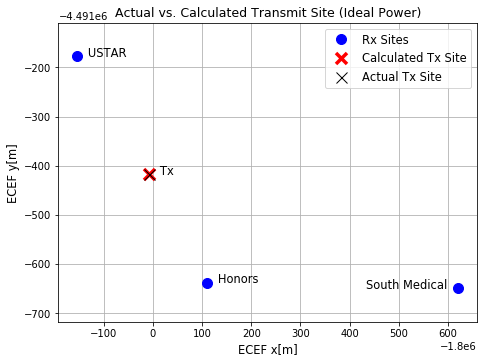

In [12]:
### Locating the Transmitter Using Ideal Power

x,y = fsolve(eqn467, (xAve, yAve)) # These are the Actual x,y
print(xTran, yTran, x, y, xAve, yAve, eqn467((x, y)), gam64, gam76)
print 'Calculated Tx (x,y):', x, y
print 'Actual Tx (x,y):', xTran, yTran
print 'Computed Transmit Location (Lat, Lon):', xyz2LatLon(x, y, zTran) # Computed Tx site
print 'Actual Transmit Location (Lat, Lon):  ', tranLat, tranLon      # Actual Tx site
print '---------- Error ----------'
print 'Computed error in meters:', haverDist2(xyz2LatLon(x, y, zTran), (tranLat, tranLon, 0.0)) # Transmit z = 0.0
print 'Actual error in meters:', haverDist2(xyz2LatLon(xTran, yTran, zTran), (tranLat, tranLon, 0.0))

pylab.figure(figsize=(7.5,5.5)) 
pylab.plot([x4,x6,x7], [y4,y6,y7], 'bo', markersize=10.0, label='Rx Sites')
plt.text(x4,y4,'   Honors', fontsize=11.5); 
plt.text(x6,y6,'South Medical   ', horizontalalignment='right', fontsize=11.5); 
plt.text(x7,y7,'   USTAR', fontsize=11.5)
plt.text(x,y,'   Tx', fontsize=11.5)
pylab.plot([x], [y], 'rx',mew=3.5, markersize=11.0, label='Calculated Tx Site')
pylab.plot([xTran], [yTran], 'kx',mew=1.0, markersize=11.0, label='Actual Tx Site')
plt.xlabel('ECEF x[m]', fontsize=11.5)
plt.ylabel('ECEF y[m]', fontsize=11.5)
plt.title('Actual vs. Calculated Transmit Site (Ideal Power)', fontsize=12.5)
pylab.grid()
pylab.axis('equal')
pylab.legend(loc='upper right', fontsize=11.5)
plt.savefig('PowerGeo.svg', bbox_inches='tight')

/home/jon/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/jon/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Input Standard Deviation: 1.0
Power Standard Deviation (x,y) [m]: 65.7836780518 38.913610871
Average Tx Site (xAve, yAve): -1799807.9053 -4491488.29991
Power Mean (x_bar, y_bar): -1800004.10360263 -4491407.355298854
Power Variance (xVar, yVar): 4327.49229802 1514.26911102
 
What is Close? The following gives the number of Standard Deviations apart:
Power (X): 2.9824769663823467
Power (Y): -2.080110546985849


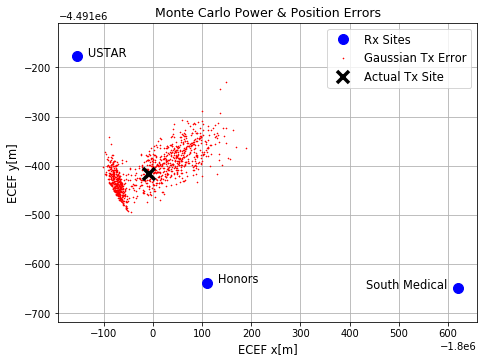

In [13]:
### Monte Carlo Power and Position Errors
pylab.figure(figsize=(7.5,5.5))
pylab.plot([x4,x6,x7],[y4,y6,y7],'bo',markersize=10.0, label='Rx Sites')
plt.text(x4,y4,'   Honors', fontsize=11.5); 
plt.text(x6,y6,'South Medical   ', horizontalalignment='right', fontsize=11.5); 
plt.text(x7,y7,'   USTAR', fontsize=11.5)
plt.title('Monte Carlo Power & Position Errors', fontsize=12.5)
plt.xlabel('ECEF x[m]', fontsize=11.5)
plt.ylabel('ECEF y[m]', fontsize=11.5)
pylab.grid()
pylab.axis('equal') 

Pwr_xList=[]; Pwr_yList=[]; 
p4N=[]; p6N=[]; p7N=[] # Power in dB (10*log10) with random Gaussian error 
p4_N=[]; p6_N=[]; p7_N=[] # Power ratio (10^(p/10)) using the power above^
p4 = 10.0*math.log10(1/(tXrXDist['Honors']**2)) 
p6 = 10.0*math.log10(1/(tXrXDist['SouthMedical']**2))
p7 = 10.0*math.log10(1/(tXrXDist['SMBB']**2))

Pwr_stdev = 1.0 # INPUT STANDARD DEVIATION (dB)
for k in range(0,1000):  
    
    ## Receive power converted to dB and added Random Gaussian
    ## error with standard deviation 
    p4_err = p4 + np.random.normal(0.0, Pwr_stdev)
    p4N.append(p4_err)
    p6_err = p6 + np.random.normal(0.0, Pwr_stdev)
    p6N.append(p6_err)
    p7_err = p7 + np.random.normal(0.0, Pwr_stdev) 
    p7N.append(p7_err)

    ## New converted Power with error
    p4New = (10.0)**(p4_err/10.0) 
    p4_N.append(p4New)
    p6New = (10.0)**(p6_err/10.0)
    p6_N.append(p6New)
    p7New = (10.0)**(p7_err/10.0)
    p7_N.append(p7New)
   
    ## New Ratios 
    gam64 = p6New/p4New 
    gam76 = p7New/p6New
    
    # xAve = (x4+x6+x7)/3; yAve = (y4+y6+y7)/3
    xMonte, yMonte = fsolve(eqn467, (xAve, yAve)) # Plot Transmit Location
    Pwr_xList.append(xMonte); Pwr_yList.append(yMonte)

pylab.plot(Pwr_xList, Pwr_yList,'rx',markersize=1.0,label='Gaussian Tx Error') # Plot the red dots (Error)
pylab.plot([x], [y], 'kx', mew=3.5, markersize=12.5, label='Actual Tx Site') # Plot black 'X', the actual Tx site
pylab.legend(loc='upper right', fontsize=11.5)
plt.savefig('PowerMonteCarlo.svg',  bbox_inches='tight')
#------------------------------------------------------------------------------------------------------------------

print 'Input Standard Deviation:', Pwr_stdev
Pwr_stdDevX = std_dev(Pwr_xList); Pwr_stdDevY = std_dev(Pwr_yList) # Standard Deviation for x & y Lists
print 'Power Standard Deviation (x,y) [m]:', Pwr_stdDevX, Pwr_stdDevY
print 'Average Tx Site (xAve, yAve):', xAve, yAve
print 'Power Mean (x_bar, y_bar):', mean(Pwr_xList, len(Pwr_xList)), mean(Pwr_yList, len(Pwr_yList))
print 'Power Variance (xVar, yVar):', var(Pwr_xList), var(Pwr_yList)
print ' '
print 'What is Close? The following gives the number of Standard Deviations apart:'
print 'Power (X):', (xAve - mean((Pwr_xList),len(Pwr_xList)))/std_dev(Pwr_xList)
print 'Power (Y):', (yAve - mean((Pwr_yList),len(Pwr_yList)))/std_dev(Pwr_yList)

In [14]:
### Geolocation Through TDOA 

# Time Difference of Arrival  does not require the time that the signal was sent from the 
# target, only the time the signal was received and the speed that the signal travels.
# Once the signal is received at two reference points, the difference in arrival time can be
# used to calculate the difference in distances between the target and the two reference points.
# https://onlinelibrary.wiley.com/doi/full/10.4218/etrij.17.0116.0554

# Solve for the transmit location using TDOA 
def tdoa467(p): # Receivers: Honors Dorm(4), South Medical Tower(6), SMBB(7)
    global t67,t74,x4,x6,x7,y4,y6,y7,c
    #x,y = p 
    x,y = p
    d4 = math.sqrt((x4 - x)**2 + (y4 - y)**2) 
    d6 = math.sqrt((x6 - x)**2 + (y6 - y)**2) 
    d7 = math.sqrt((x7 - x)**2 + (y7 - y)**2)
    
    return(t67 - ((d6/c) - d7/c), 
           t74 - ((d7/c) - d4/c))

tdoa67: 1.29652798158e-06 --- tdoa74: 1.01386707929e-07
 
Calculated Tx (x,y): -1800007.1858904136 -4491417.006311179
Actual Tx (x,y): -1800007.18602 -4491417.00644
 
Calculated error in meters: 0.000130825723261
Actual error in meters: 7.07324088189e-10


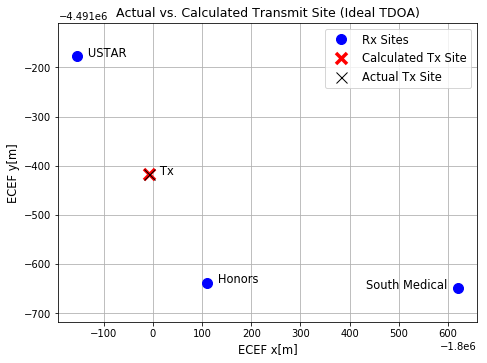

In [15]:
xMac, yMac, zMac = transmitXYZ['McarthyCenter'] # Center of McCarthy Track & Field

def d(xMac, yMac, xRec, yRec): # Cartesian Distance Formula for 2-Dimensions
    dist = math.sqrt(((xRec) - xMac)**2 + ((yRec) - yMac)**2)
    return dist
            
dist = {
    'BEHS': d(xMac, yMac, x0, y0),            # 0
    'Browning': d(xMac, yMac, x1, y1),        # 1
    'Dentistry': d(xMac, yMac, x2, y2),       # 2
    'FriendshipManor': d(xMac, yMac, x3, y3), # 3
    'Honors': d(xMac, yMac, x4, y4),          # 4
    'MEB': d(xMac, yMac, x5, y5),             # 5 
    'SouthMedical': d(xMac, yMac, x6, y6),    # 6
    'SMBB': d(xMac, yMac, x7, y7),            # 7
}

c = 299792458.0 # Speed of light [m/sec]
t67 = (dist['SouthMedical']/c) - (dist['SMBB']/c)
t74 = (dist['SMBB']/c) - (dist['Honors']/c)
print 'tdoa67:', t67, '--- tdoa74:', t74
print ' '
x, y = fsolve(tdoa467, (xAve, yAve)) # These are the Actual x,y of the transmitter in meters
print 'Calculated Tx (x,y):', x, y
print 'Actual Tx (x,y):', xTran, yTran
print ' '
print 'Calculated error in meters:', haverDist2(xyz2LatLon(x, y, zTran), (tranLat, tranLon, 0.0)) # Tx z = 0.0
print 'Actual error in meters:', haverDist2(xyz2LatLon(xTran, yTran, zTran), (tranLat, tranLon, 0.0)) # Tx z = 0.0

pylab.figure(figsize=(7.5,5.5))
pylab.plot([x4,x6,x7], [y4,y6,y7], 'bo',markersize=10.0, label='Rx Sites')
plt.text(x4,y4,'   Honors', fontsize=11.5); 
plt.text(x6,y6,'South Medical   ', horizontalalignment='right', fontsize=11.5); 
plt.text(x7,y7,'   USTAR', fontsize=11.5)
plt.text(x,y,'   Tx', fontsize=11.5)
pylab.plot([x], [y], 'rx',mew=3.5, markersize=11.0, label='Calculated Tx Site')
pylab.plot([xTran], [yTran], 'kx',mew=1.0, markersize=11.0, label='Actual Tx Site')
#pylab.plot([xTran], [yTran], 'kx',mew=1.5, markersize=11.0, label='Actual Tx')
plt.title('Actual vs. Calculated Transmit Site (Ideal TDOA)', fontsize=12.5)
plt.xlabel('ECEF x[m]', fontsize=11.5)
plt.ylabel('ECEF y[m]', fontsize=11.5)
pylab.grid()
pylab.axis('equal')
pylab.legend(loc='upper right', fontsize=11.5)
plt.savefig('TdoaGeo.svg', bbox_inches='tight')
# 0.131 mm

Input Standard Deviation: 1e-07
 
Average Tx Site (x,y): -1799807.9053 -4491488.29991
TDOA Standard Deviation (x,y) [m]: 57.762574823 46.124557952
TDOA Mean (x_bar, y_bar): -1800013.2776968093 -4491419.962600745
Power Variance (xVar, yVar): 4327.49229802 1514.26911102
 
What is Close? The following gives the number of Standard Deviations apart:
TDOA (X): 3.5554578264887082
TDOA (Y): -1.4815819064175353


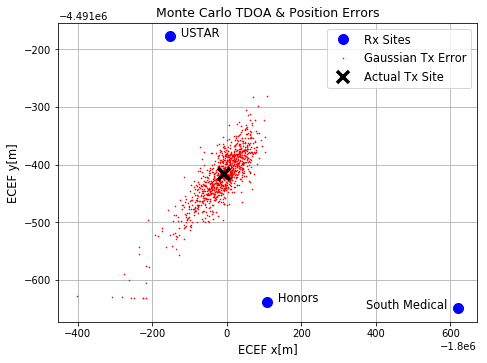

In [16]:
# The main goal of Monte Carlo is to use repeated random sampling 
# to obtain numerical results. The most straightforward algorithm 
# for Monte Carlo can basically be broken down into the following steps:

#    1) Get some random input
#    2) Evaluate
#    3) Repeat steps 1 and 2 as needed (To improve accuracy, more is better)
#    4) Determine the average of all these samples and multiply by the range

pylab.figure(figsize=(7.5,5.5))
pylab.plot([x4,x6,x7],[y4,y6,y7],'bo',markersize=10.0, label='Rx Sites')
plt.text(x4,y4,'   Honors', fontsize=11.5); 
plt.text(x6,y6,'South Medical   ', horizontalalignment='right', fontsize=11.5); 
plt.text(x7,y7,'   USTAR', fontsize=11.5)
plt.title('Monte Carlo TDOA & Position Errors', fontsize=12.5)
plt.xlabel('ECEF x[m]', fontsize=11.5)
plt.ylabel('ECEF y[m]', fontsize=11.5)
pylab.grid()
# pylab.axis('equal') 

Tdoa_xList=[]; Tdoa_yList=[]; t4N=[]; t6N=[]; t7N=[]; tdoa67=[]; tdoa74=[]
t_67 = (dist['SouthMedical']/c) - (dist['SMBB']/c)
t_74 = (dist['SMBB']/c) - (dist['Honors']/c)
R4 = dist['Honors']
R6 = dist['SouthMedical']
R7 = dist['SMBB']

Tdoa_stdev = 100e-9 # INPUT STANDARD DEVIATION
n = 1000
for k in range(0,n):  
    
    ## Adding random Gaussian error
    t4 = (R4/c) + np.random.normal(0.0, Tdoa_stdev)
    t4N.append(t4)
    t6 = (R6/c) + np.random.normal(0.0, Tdoa_stdev)
    t6N.append(t6)
    t7 = (R7/c) + np.random.normal(0.0, Tdoa_stdev)
    t7N.append(t7)
    
    t67 = t6 - t7
    tdoa67.append(t67)
    t74 = t7 - t4
    tdoa74.append(t74)
    
    xMonte, yMonte = fsolve(tdoa467, (xAve, yAve)) # Plot Transmit Location
    Tdoa_xList.append(xMonte); Tdoa_yList.append(yMonte)
    
    t67_Err = math.sqrt((tdoa67[k] - t_67)**2)
    t74_Err = math.sqrt((tdoa74[k] - t_74)**2)

pylab.plot(Tdoa_xList, Tdoa_yList,'rx',markersize=1.0,label='Gaussian Tx Error') # Plot the red dots (Error)
pylab.plot([x], [y], 'kx', mew=3.5, markersize=12.5, label='Actual Tx Site') # Plot black 'X', the actual Tx site
pylab.legend(loc='upper right', fontsize=11.5)
plt.savefig('TdoaMonteCarlo.svg',  bbox_inches='tight')
#------------------------------------------------------------------------------------------------------------------

print 'Input Standard Deviation:', Tdoa_stdev
print ' '
print 'Average Tx Site (x,y):', xAve, yAve
Tdoa_stdDevX = std_dev(Tdoa_xList); Tdoa_stdDevY = std_dev(Tdoa_yList) # Standard Deviation for x & y Lists
print 'TDOA Standard Deviation (x,y) [m]:', Tdoa_stdDevX, Tdoa_stdDevY
print 'TDOA Mean (x_bar, y_bar):', mean(Tdoa_xList, len(Tdoa_xList)), mean(Tdoa_yList, len(Tdoa_yList))
print 'Power Variance (xVar, yVar):', var(Pwr_xList), var(Pwr_yList) 
print ' '
print 'What is Close? The following gives the number of Standard Deviations apart:'
print 'TDOA (X):', (xAve - mean((Tdoa_xList),len(Tdoa_xList)))/std_dev(Tdoa_xList)
print 'TDOA (Y):', (yAve - mean((Tdoa_yList),len(Tdoa_yList)))/std_dev(Tdoa_yList)

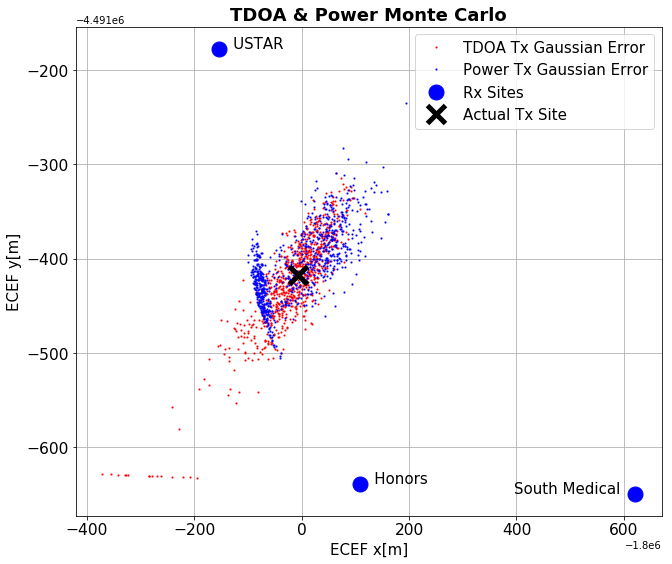

In [17]:
pylab.figure(figsize=(10.5,9.0))
plt.text(x4,y4,'   Honors', fontsize=15); 
plt.text(x6,y6,'South Medical   ', horizontalalignment='right', fontsize=15); 
plt.text(x7,y7,'   USTAR', fontsize=15)
plt.title('TDOA & Power Monte Carlo', fontsize=18, fontweight='bold')
#plt.axes.labelsize = 15
matplotlib.pyplot.xticks(fontsize=15.5)
matplotlib.pyplot.yticks(fontsize=15.5)
plt.xlabel('ECEF x[m]', fontsize=15)
plt.ylabel('ECEF y[m]', fontsize=15)
pylab.grid()
# pylab.axis('equal') 

Pwr_xList=[]; Pwr_yList=[]; 
p4N=[]; p6N=[]; p7N=[] # Power in dB (10*log10) with random Gaussian error 
p4_N=[]; p6_N=[]; p7_N=[] # Power ratio (10^(p/10)) using the power above^
p4 = 10.0*math.log10(1/(tXrXDist['Honors']**2)) 
p6 = 10.0*math.log10(1/(tXrXDist['SouthMedical']**2))
p7 = 10.0*math.log10(1/(tXrXDist['SMBB']**2))
Pwr_stdev = 1.0 # Standard Deviation

Tdoa_xList=[]; Tdoa_yList=[]; t4N2=[]; t6N2=[]; t7N2=[]; tdoa67=[]; tdoa74=[]
t_67 = (dist['SouthMedical']/c) - (dist['SMBB']/c)
t_74 = (dist['SMBB']/c) - (dist['Honors']/c)
R4 = dist['Honors']
R6 = dist['SouthMedical']
R7 = dist['SMBB']

n = 800
for k in range(0,n):  
    # POWER
    p4_err = p4 + np.random.normal(0.0, Pwr_stdev)
    p4N.append(p4_err)
    p6_err = p6 + np.random.normal(0.0, Pwr_stdev)
    p6N.append(p6_err)
    p7_err = p7 + np.random.normal(0.0, Pwr_stdev) 
    p7N.append(p7_err)

    ## New converted Power with error
    p4New = (10.0)**(p4_err/10.0) 
    p4_N.append(p4New)
    p6New = (10.0)**(p6_err/10.0)
    p6_N.append(p6New)
    p7New = (10.0)**(p7_err/10.0)
    p7_N.append(p7New)
    
    # New Ratios 
    gam64 = p6New/p4New 
    gam76 = p7New/p6New
    
    # TDOA
    t4 = (R4/c) + np.random.normal(0.0, Tdoa_stdev)
    t4N2.append(t4)
    t6 = (R6/c) + np.random.normal(0.0, Tdoa_stdev)
    t6N2.append(t6)
    t7 = (R7/c) + np.random.normal(0.0, Tdoa_stdev)
    t7N2.append(t7)
    
    t67 = t6 - t7
    tdoa67.append(t67)
    t74 = t7 - t4
    tdoa74.append(t74)
    
    xMonte, yMonte = fsolve(eqn467, (xAve, yAve)) # Plot Transmit Location
    Pwr_xList.append(xMonte); Pwr_yList.append(yMonte)
    
    tdoa_xMonte, tdoa_yMonte = fsolve(tdoa467, (xAve, yAve)) # Plot Transmit Location
    Tdoa_xList.append(tdoa_xMonte); Tdoa_yList.append(tdoa_yMonte)

# Plot TDOA
pylab.plot(Tdoa_xList, Tdoa_yList,'rx',markersize=1.5, label='TDOA Tx Gaussian Error') # Plot the red dots 

# Plot Power
pylab.plot(Pwr_xList, Pwr_yList,'bx', markersize=1.5,label='Power Tx Gaussian Error') # Plot the blue dots 
pylab.plot([x4,x6,x7],[y4,y6,y7],'bo',markersize=15.0, label='Rx Sites')
pylab.plot([x], [y], 'kx', mew=5, markersize=17.5, label='Actual Tx Site') # Plot black 'X', the actual Tx site
pylab.legend(loc='upper right', fontsize=15)
plt.savefig('CombinedTdoaAndPowerMonteCarlo.svg',  bbox_inches='tight')

In [18]:
print '-------------------------------------- POWER VS. TDOA --------------------------------------'
print ' '
###################################################################################################################
print 'MEAN:'
print 'Average Tx Site (x,y):', xAve, yAve
print 'Actual Tx Site (x,y):', xTran, yTran
print 'Power Mean (x_bar, y_bar):', mean(Pwr_xList, len(Pwr_xList)), mean(Pwr_yList, len(Pwr_yList))
print 'TDOA Mean (x_bar, y_bar):', mean(Tdoa_xList, len(Tdoa_xList)), mean(Tdoa_yList, len(Tdoa_yList)); print ' '

print 'STANDARD DEVIATION:'
Pwr_stdDevX = std_dev(Pwr_xList); Pwr_stdDevY = std_dev(Pwr_yList) # Standard Deviation for x & y Lists
print 'Power Standard Deviation (x,y) [m]:', Pwr_stdDevX, Pwr_stdDevY
Tdoa_stdDevX = std_dev(Tdoa_xList); Tdoa_stdDevY = std_dev(Tdoa_yList) # Standard Deviation for x & y Lists
print 'TDOA Standard Deviation (x,y) [m]:', Tdoa_stdDevX, Tdoa_stdDevY; print ' '

print 'VARIANCE:'
print 'Power Variance (xVar, yVar):', var(Pwr_xList), var(Pwr_yList)
print 'TDOA Variance (xVar, yVar):', var(Tdoa_xList), var(Tdoa_yList); print ' '

print 'COVARIANCE:'
geo_Cov_x = cov(Pwr_xList, Tdoa_xList, len(Tdoa_xList))
geo_Cov_y = cov(Pwr_yList, Tdoa_yList, len(Tdoa_yList))
print 'Power & TDOA Covariance (X):', geo_Cov_x
print 'Power & TDOA Covariance (Y):', geo_Cov_y; print ' '

print 'CORRELATION'
x_corr = cov(Pwr_xList, Tdoa_xList, n)/math.sqrt(var(Pwr_xList)*var(Tdoa_xList))
y_corr = cov(Pwr_yList, Tdoa_yList, n)/math.sqrt(var(Pwr_yList)*var(Tdoa_yList))
print 'Power & TDOA Correlation (X,Y):', x_corr, ',', y_corr; print ' '

print 'WHAT IS CLOSE? The following gives the number of Standard Deviations apart:'
print 'Power (X):', (xAve - mean((Pwr_xList),len(Pwr_xList)))/std_dev(Pwr_xList)
print 'Power (Y):', (yAve - mean((Pwr_yList),len(Pwr_yList)))/std_dev(Pwr_yList); print ' '

print 'TDOA (X):', (xAve - mean((Tdoa_xList),len(Tdoa_xList)))/std_dev(Tdoa_xList)
print 'TDOA (Y):', (yAve - mean((Tdoa_yList),len(Tdoa_yList)))/std_dev(Tdoa_yList); print ' '

# GEOLOCATION THROUGH TIMING AND POWER ********************
# We wish to combine two different measurements in any way that might improve accuracy. 
# Say I have an error of n1 using measurements A and an error of n2 using measurements B. 
# Can I do better than both n1 and n2 by using both sets of information? 

Pwr_xAve = mean(Pwr_xList, len(Pwr_xList)); Pwr_yAve = mean(Pwr_yList, len(Pwr_yList))
Tdoa_xAve = mean(Tdoa_xList, len(Tdoa_xList)); Tdoa_yAve = mean(Tdoa_yList, len(Tdoa_yList))
x_bar = (Pwr_xAve/(var(Pwr_xList)) + Tdoa_xAve/(var(Tdoa_xList))) / (1/var(Pwr_xList) + 1/var(Tdoa_xList))
y_bar = (Pwr_yAve/(var(Pwr_yList)) + Tdoa_yAve/(var(Tdoa_yList))) / (1/var(Pwr_yList) + 1/var(Tdoa_yList))
combined_xVar = 1/(1/var(Pwr_xList) + 1/var(Tdoa_xList))
combined_yVar = 1/(1/var(Pwr_yList) + 1/var(Tdoa_yList))

print 'GEOLOCATION THROUGH BOTH TIMING & POWER:' 
print '                     Actual Tx Site (x,y):', xTran, yTran
print 'Power & TDOA Combined Mean (x_bar, y_bar):', x_bar, y_bar
print 'Power & TDOA Combined Variance (xVar, yVar):', combined_xVar, combined_yVar 
print 'x_bar/combined_xVar, y_bar/combined_yVar:', x_bar/combined_xVar, y_bar/combined_yVar
print ' '
x_bar2 = (Pwr_xAve/(var(Pwr_xList)) + Tdoa_xAve/(var(Tdoa_xList))) / (1/var(Pwr_xList) + 1/var(Tdoa_xList))*(1/var(Pwr_xList) + 1/var(Tdoa_xList))
y_bar2 = (Pwr_yAve/(var(Pwr_yList)) + Tdoa_yAve/(var(Tdoa_yList))) / (1/var(Pwr_yList) + 1/var(Tdoa_yList))*(1/var(Pwr_yList) + 1/var(Tdoa_yList))

print 'x_bar2:', x_bar2
print 'y_bar2:', y_bar2


-------------------------------------- POWER VS. TDOA --------------------------------------
 
MEAN:
Average Tx Site (x,y): -1799807.9053 -4491488.29991
Actual Tx Site (x,y): -1800007.18602 -4491417.00644
Power Mean (x_bar, y_bar): -1800007.489227072 -4491406.948465838
TDOA Mean (x_bar, y_bar): -1800016.5701018816 -4491423.418879291
 
STANDARD DEVIATION:
Power Standard Deviation (x,y) [m]: 65.4915190889 38.372435446
TDOA Standard Deviation (x,y) [m]: 62.6484145158 50.740566748
 
VARIANCE:
Power Variance (xVar, yVar): 4289.13907257 1472.44380206
TDOA Variance (xVar, yVar): 3924.82384134 2574.6051139
 
COVARIANCE:
Power & TDOA Covariance (X): -138.5690484515173
Power & TDOA Covariance (Y): 27.928985705838645
 
CORRELATION
Power & TDOA Correlation (X,Y): -0.0337731124557045 , 0.014344337198910793
 
WHAT IS CLOSE? The following gives the number of Standard Deviations apart:
Power (X): 3.047477471462566
Power (Y): -2.120049052527403
 
TDOA (X): 3.3307276076755974
TDOA (Y): -1.27868165682386

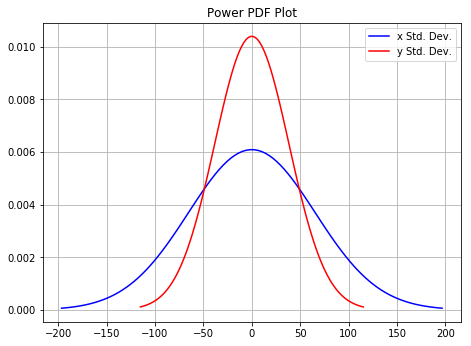

Averages (xList, yList): -1800007.4892270705 , -4491406.948465832
Standard Deviations (xList, yList): 65.4915190889 , 38.372435446
-1799806.2096098473 -4491235.54795626
-1800099.8884236845 -4491504.970442415


In [19]:
###################################################################################################################
# FUTURE / ON-GOING WORK & NOTES 
###################################################################################################################
# POWER

def std_dev(a_list): # Computes the Standard Deviation, taken from Alex Orange
    mean = sum(a_list)/len(a_list)
    return math.sqrt(sum([(_-mean)**2 for _ in a_list])/(len(a_list)-1))

def var(a_list):
    mean = sum(a_list)/len(a_list)
    return(math.sqrt(sum([(_-mean)**2 for _ in a_list])/(len(a_list)-1))**2)

Pwr_x_mu = 0 #sum(xList)/len(xList)
Pwr_x_var = var(Pwr_xList)
Pwr_x_sigma = std_dev(Pwr_xList)
Pwr_x_sigma_weight = 3
Pwr_xPart = np.linspace(Pwr_x_mu - Pwr_x_sigma_weight*Pwr_x_sigma, Pwr_x_mu + Pwr_x_sigma_weight*Pwr_x_sigma, 100)

Pwr_y_mu = 0 #sum(yList)/len(yList)
Pwr_y_var = var(Pwr_yList)
Pwr_y_sigma = std_dev(Pwr_yList)
Pwr_y_sigma_weight = 3
Pwr_yPart = np.linspace(Pwr_y_mu - Pwr_y_sigma_weight*Pwr_y_sigma, Pwr_y_mu + Pwr_y_sigma_weight*Pwr_y_sigma, 100)

plt.figure(figsize=(7.5,5.5))
plt.title('Power PDF Plot')
plt.plot(Pwr_xPart, stats.norm.pdf(Pwr_xPart, Pwr_x_mu, Pwr_x_sigma),'b-', label='x Std. Dev.')
plt.plot(Pwr_yPart, stats.norm.pdf(Pwr_yPart, Pwr_y_mu, Pwr_y_sigma),'r-', label='y Std. Dev.')
plt.grid(); plt.legend(); plt.show()

# print 'Comparing Power Numbers ', p4, (1/(tXrXDist['Honors']**2)), 10**(p4/10.0)
print 'Averages (xList, yList):', (sum(Pwr_xList)/len(Pwr_xList)), ',', (sum(Pwr_yList)/len(Pwr_yList))
print 'Standard Deviations (xList, yList):', std_dev(Pwr_xList), ',', std_dev(Pwr_yList)
print max(Pwr_xList), max(Pwr_yList)
print min(Pwr_xList), min(Pwr_yList)

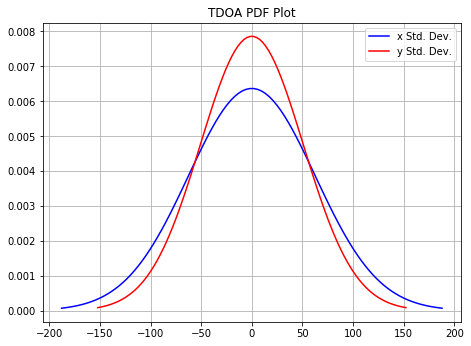

Averages (xList, yList): -1800016.5701018823 , -4491423.418879293
Standard Deviations (xList, yList): 62.6484145158 , 50.740566748


In [20]:
###################################################################################################################
# TDOA

Tdoa_x_mu = 0 #sum(xList)/len(xList)
Tdoa_x_var = var(Tdoa_xList)
Tdoa_x_sigma = std_dev(Tdoa_xList)
Tdoa_x_sigma_weight = 3
Tdoa_xPart = np.linspace(Tdoa_x_mu - Tdoa_x_sigma_weight*Tdoa_x_sigma, Tdoa_x_mu + Tdoa_x_sigma_weight*Tdoa_x_sigma, 100)

Tdoa_y_mu = 0 #sum(yList)/len(yList)
Tdoa_y_var = var(Tdoa_yList)
Tdoa_y_sigma = std_dev(Tdoa_yList)
Tdoa_y_sigma_weight = 3
Tdoa_yPart = np.linspace(Tdoa_y_mu - Tdoa_y_sigma_weight*Tdoa_y_sigma, Tdoa_y_mu + Tdoa_y_sigma_weight*Tdoa_y_sigma, 100)

plt.figure(figsize=(7.5,5.5))
plt.title('TDOA PDF Plot')
plt.plot(Tdoa_xPart, stats.norm.pdf(Tdoa_xPart, Tdoa_x_mu, Tdoa_x_sigma),'b-', label='x Std. Dev.')
plt.plot(Tdoa_yPart, stats.norm.pdf(Tdoa_yPart, Tdoa_y_mu, Tdoa_y_sigma),'r-', label='y Std. Dev.')
plt.grid(); plt.legend(); plt.show()

# print 'Comparing Power Numbers ', p4, (1/(tXrXDist['Honors']**2)), 10**(p4/10.0)
print 'Averages (xList, yList):', (sum(Tdoa_xList)/len(Tdoa_xList)), ',', (sum(Tdoa_yList)/len(Tdoa_yList))
print 'Standard Deviations (xList, yList):', std_dev(Tdoa_xList), ',', std_dev(Tdoa_yList)

In [21]:
# Function to find covariance
# Source: https://www.geeksforgeeks.org/program-find-covariance/
#  Covariance is a measure of how much two random variables vary together
def cov(arr1, arr2, n): 
    s = 0.0
    for i in range(0, n): 
        s = (s + (arr1[i] - mean(arr1, n)) *
                      (arr2[i] - mean(arr2, n))) 
    return s / (n - 1.0)  
    
print 'Pwr_xList/ Tdoa_xList Covariance:', cov(Pwr_xList, Tdoa_xList, len(Tdoa_xList))
print 'Pwr_yList/ Tdoa_yList Covariance:', cov(Pwr_yList, Tdoa_yList, len(Tdoa_yList))

Pwr_xList/ Tdoa_xList Covariance: -138.5690484515173
Pwr_yList/ Tdoa_yList Covariance: 27.928985705838645


In [22]:
# Correlation commonly refers to the degree to which a pair of variables are linearly related

x_corr = cov(Pwr_xList, Tdoa_xList, n)/math.sqrt(var(Pwr_xList)*var(Tdoa_xList))
print 'x_corr:', x_corr

y_corr = cov(Pwr_yList, Tdoa_yList, n)/math.sqrt(var(Pwr_yList)*var(Tdoa_yList))
print 'y_corr:', y_corr

print 'Pwr_xList/ Tdoa_xList Covariance:', cov(Pwr_xList, Tdoa_xList, len(Tdoa_xList))
print 'Pwr_yList/ Tdoa_yList Covariance:', cov(Pwr_yList, Tdoa_yList, len(Tdoa_yList))

x_corr: -0.0337731124557045
y_corr: 0.014344337198910793
Pwr_xList/ Tdoa_xList Covariance: -138.5690484515173
Pwr_yList/ Tdoa_yList Covariance: 27.928985705838645


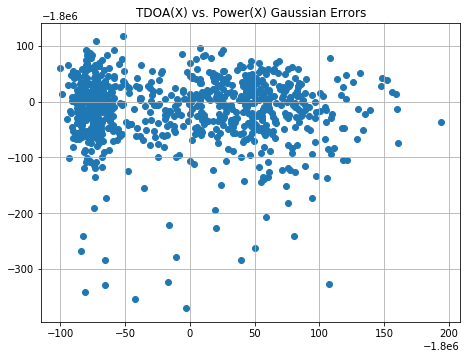

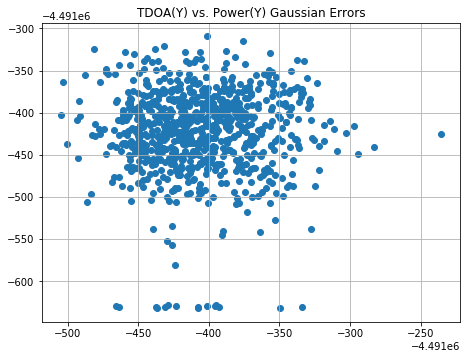

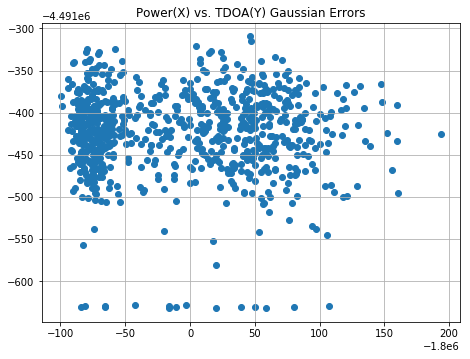

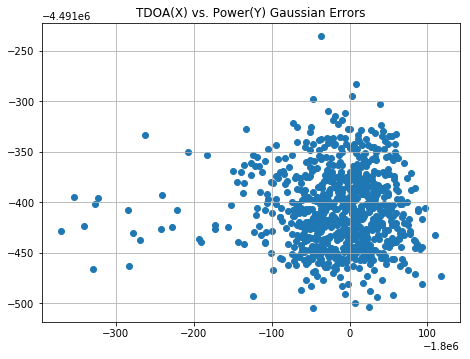

In [23]:
pyplot.figure(figsize=(7.5,5.5))
pyplot.title('TDOA(X) vs. Power(X) Gaussian Errors')
pyplot.scatter(Pwr_xList, Tdoa_xList)
pyplot.grid(); pyplot.show()

pyplot.figure(figsize=(7.5,5.5))
pyplot.title('TDOA(Y) vs. Power(Y) Gaussian Errors')
pyplot.scatter(Pwr_yList, Tdoa_yList)
pyplot.grid(); pyplot.show()

pyplot.figure(figsize=(7.5,5.5))
pyplot.title('Power(X) vs. TDOA(Y) Gaussian Errors')
pyplot.scatter(Pwr_xList, Tdoa_yList)
pyplot.grid(); pyplot.show()

pyplot.figure(figsize=(7.5,5.5))
pyplot.title('TDOA(X) vs. Power(Y) Gaussian Errors')
pyplot.scatter(Tdoa_xList, Pwr_yList)
pyplot.grid(); pyplot.show()

### ERROR ELLIPSE: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html